# QR Constraint Networks 101

This notebook provides a brief example of how a <i>qualreas</i> <b>Constraint Network Object</b> can be...
* represented in JSON or Python dictionary formats
* instantiated from a JSON file or Python dictionary
* serialized to a JSON file/string or Python dictionary
* summarized
* propagated
* queried for details about node and edge attributes
* used to generate all consistent singleton labellings when multiple constraints (relations) are involved

Two different types of contraint algebras are used here:
1. The spatial constraint algebra, [Region Connection Calculus 8 (RCC8)](https://en.wikipedia.org/wiki/Region_connection_calculus)
1. The temporal interval & point algebra defined by Reich in ["Intervals, Points, and Branching Time", 1994](https://www.researchgate.net/publication/220810644_Intervals_Points_and_Branching_Time)

## Imports

In [1]:
import qualreas as qr
import os
from IPython.display import Image

## Path to Network & Algebra

To begin, we will instantiate a Constraint Network and it's corresponding Algebra from two JSON files.

Each are kept in separate directories, 'Networks' and 'Algebras', within a top-level 'qualreas' directory, with the full path defined here using an environment variable:

In [2]:
qr_path = os.path.join(os.getenv('PYPROJ'), 'qualreas')

Once defined, an Algebra's JSON format should remain unchanged. The name of the Algebra used by a Network can then be stored in the Network's definition (in JSON) regardless of where the Network's JSON file resides.  So, we only need provide the path to the directory containing Algebra files:

In [3]:
alg_dir = os.path.join(qr_path, "Algebras")

Networks, on the other hand, could be numerous and change often.  So, we need to provide the full path to the Network's JSON file.

In [4]:
rcc8_file = os.path.join(qr_path, "Networks", "rcc8_example.json")

## Constraint Network in JSON Format

Here's what a network looks like in JSON format.

A node is represented as a list of two things:
1. Node ID (i.e., Node Name)
1. List of ontology classes the node belongs to (e.g., "ProperInterval", "Region")

> NOTE: Networks that are based on simple relation algebras, such as Allen's Interval Algebra and the Region Connection Calculus, only involve relations among <i>entities</i> that are all from the same ontology class, such as Proper Time Intervals or Spatial Regions.  So, the <b>ontology classes of entities being related by the relations</b> does not need to be considered when, for example, composing relations.  However, when ontology classes are integrated, such as Proper Time Intervals and Time Points, then the ontology classes of the entities being related become important.

An edge is represented as a list of three things, representing a directed edge, labeled with a constraint:
1. Tail Node ID
1. Head Node ID
1. Constraint

See graphical depiction below:

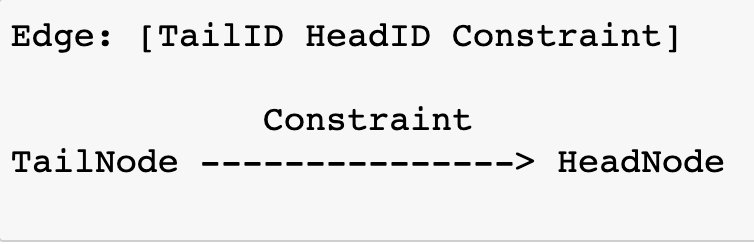

In [5]:
Image("Images/Edge_Notation_Meaning.png", width=300, height=100)

The network, shown in JSON format below, is the example from the Wikipedia page on the Region Connection Calculus (RCC8). The URL is in the "description" field.

In [6]:
!cat {rcc8_file}

{
    "name": "Wikipedia RCC8 Example",
    "algebra": "RCC8_Algebra",
    "abbreviations": {"dec": "DC|EC"},
    "description": "See https://en.wikipedia.org/wiki/Region_connection_calculus#Examples",
    "nodes": [
        ["House1", ["Region"]],
        ["House2", ["Region"]],
        ["Property1", ["Region"]],
        ["Property2", ["Region"]],
        ["Road", ["Region"]]
    ],
    "edges": [
        ["House1", "House2", "DC"],
        ["House1", "Property1", "TPP|NTPP"],
        ["House1", "Property2", "dec"],
        ["House1", "Road", "EC"],
        ["House2", "Property1", "dec"],
        ["House2", "Property2", "NTPP"],
        ["House2", "Road", "EC"],
        ["Property1", "Property2", "dec"],
        ["Road", "Property1"],
        ["Road", "Property2"]
    ]
}

NOTES:
1. The Wikipedia page on RCC8 represents disjunctions of constraints as sets, e.g., {DC, EC}, whereas QR represents this with the string "DC|EC".  Constraint sets represent disjunctions of relation statements, e.g., (Tail DC|EC Head) <==> (Tail DC Head) OR (Tail EC Head).
1. For convenience, constraints can be abbreviated using a dictionary of abbreviations.  For example, the constraint "DC|EC", above, is abbreviated as "dec".  By the way, internally, the QR module stores and operates on constraint sets as [bitsets](https://bitsets.readthedocs.io/en/stable/).
1. No constraints are given for the Road-to-Property1 or Road-to-Property2 edges.  The meaning then is that all RCC8 relations are possible for those two edges.  This can be seen in the first summary of the network farther below.

## Instantiate the Constraint Network Object

In [7]:
rcc8_net = qr.Network(algebra_path=alg_dir, json_file_name=rcc8_file)

The printed representation of a network provides its name and associated algebra:

In [8]:
print(rcc8_net)

<Network--Wikipedia RCC8 Example--RCC8_Algebra>


## Summarize the Network

Below is a summary of the Network Object just instantiated.

The format is:
* Network Name: Number of Nodes, Number of Edges
* Algebra Name
* Tail_ID1: Class List
    * => Head_ID1: Constraint1
    * => Head_ID2: Constraint2
    * ...
* and so on ...

In [9]:
rcc8_net.summary(show_all=True)


Wikipedia RCC8 Example: 5 nodes, 25 edges
  Algebra: RCC8_Algebra
  House1:['Region']
    => House1: EQ
    => House2: DC
    => Property1: NTPP|TPP
    => Property2: DC|EC
    => Road: EC
  House2:['Region']
    => House2: EQ
    => House1: DC
    => Property1: DC|EC
    => Property2: NTPP
    => Road: EC
  Property1:['Region']
    => Property1: EQ
    => House1: NTPPI|TPPI
    => House2: DC|EC
    => Property2: DC|EC
    => Road: DC|EC|EQ|NTPP|NTPPI|PO|TPP|TPPI
  Property2:['Region']
    => Property2: EQ
    => House1: DC|EC
    => House2: NTPPI
    => Property1: DC|EC
    => Road: DC|EC|EQ|NTPP|NTPPI|PO|TPP|TPPI
  Road:['Region']
    => Road: EQ
    => House1: EC
    => House2: EC
    => Property1: DC|EC|EQ|NTPP|NTPPI|PO|TPP|TPPI
    => Property2: DC|EC|EQ|NTPP|NTPPI|PO|TPP|TPPI


Notice that, in the network summary above, even edges between an entity and itself are included (e.g., House1 --> House1, with constraint EQ). The relation on such an edge will always be the equality relation(s) for whatever ontology class(es) the entity belongs to.  These edges are included in constraint propagation so that ontology classes are properly accounted for.

Also, the summary above shows all possible connections between nodes, including converses, which is somewhat redundant.  That is, if we know that X r Y, then we can infer that Y converse(r) X.  To see a more compact representation that lists just one link per node pair, leave the argument, <i>show_all</i>, at its default setting of <i>False</i>, as shown below.

In [10]:
rcc8_net.summary()


Wikipedia RCC8 Example: 5 nodes, 25 edges
  Algebra: RCC8_Algebra
  House1:['Region']
    => House1: EQ
    => House2: DC
    => Property1: NTPP|TPP
    => Property2: DC|EC
    => Road: EC
  House2:['Region']
    => House2: EQ
    => Property1: DC|EC
    => Property2: NTPP
    => Road: EC
  Property1:['Region']
    => Property1: EQ
    => Property2: DC|EC
    => Road: DC|EC|EQ|NTPP|NTPPI|PO|TPP|TPPI
  Property2:['Region']
    => Property2: EQ
    => Road: DC|EC|EQ|NTPP|NTPPI|PO|TPP|TPPI
  Road:['Region']
    => Road: EQ


The next two sections show how to obtain specific information about network nodes ("entities") and edges.

### Get Entity

<b>get_entity</b> returns an entity object (e.g., TemporalEntity, SpatialEntity). Use the object's methods to access it's attributes.

In [11]:
entity = rcc8_net.get_entity("House1")
entity

SpatialEntity(['Region'] 'House1')

In [12]:
entity.name

'House1'

In [13]:
entity.classes

['Region']

### Get Edge by Tail & Head Node IDs

Given a Tail ID and Head ID, <b>get_edge</b> returns an edge in the form of a tuple of three things, in order: (Tail Node ID, Head Node ID, Constraint)

In [14]:
edge = rcc8_net.get_edge("Property1", "Road")
edge

('Property1', 'Road', 'DC|EC|EQ|NTPP|NTPPI|PO|TPP|TPPI')

<b>get_constraint</b> takes the same inputs, but returns only the constraint for that edge.

In [15]:
rcc8_net.get_constraint("Property1", "Road")

'DC|EC|EQ|NTPP|NTPPI|PO|TPP|TPPI'

By the way, the Network method, <b>set_constraint</b>, can be used to set or change the constraint on an edge.  Setting the constraint on an edge, [Tail, Head], will automatically, set the converse constraint on the edge, [Head, Tail]. Always run the <b>propogate</b> method on a Network after setting/changing constraints.

## Perform Constraint Propagation

After propagation, note the change in the constraints between the Road and the two Properties.

In [16]:
rcc8_net.propagate()
rcc8_net.summary()


Wikipedia RCC8 Example: 5 nodes, 25 edges
  Algebra: RCC8_Algebra
  House1:['Region']
    => House1: EQ
    => House2: DC
    => Property1: NTPP|TPP
    => Property2: DC|EC
    => Road: EC
  House2:['Region']
    => House2: EQ
    => Property1: DC
    => Property2: NTPP
    => Road: EC
  Property1:['Region']
    => Property1: EQ
    => Property2: DC|EC
    => Road: EC|PO
  Property2:['Region']
    => Property2: EQ
    => Road: PO|TPPI
  Road:['Region']
    => Road: EQ


For comparison, the printout below is in a format similar to that found on the [Wikipedia example page](https://en.wikipedia.org/wiki/Region_connection_calculus#Examples):

In [17]:
road = "Road"
prop1 = "Property1"
prop2 = "Property2"

print(f"{road} {rcc8_net.get_constraint(road, prop1)} {prop1}")
print(f"{road} {rcc8_net.get_constraint(road, prop2)} {prop2}")

Road EC|PO Property1
Road PO|TPP Property2


## Converting Networks to/from Other Formats

### Network to Dictionary

Note: The only differences between JSON and the dictionary output by <b>to_dict</b> are the single quotes instead of double quotes required by JSON.

In [18]:
rcc8_net_dict = rcc8_net.to_dict()

rcc8_net_dict

{'name': 'Wikipedia RCC8 Example',
 'algebra': 'RCC8_Algebra',
 'description': 'See https://en.wikipedia.org/wiki/Region_connection_calculus#Examples',
 'nodes': [['House1', ['Region']],
  ['House2', ['Region']],
  ['Property1', ['Region']],
  ['Property2', ['Region']],
  ['Road', ['Region']]],
 'edges': [['House1', 'House2', 'DC'],
  ['House1', 'Property1', 'NTPP|TPP'],
  ['House1', 'Property2', 'DC|EC'],
  ['House1', 'Road', 'EC'],
  ['House2', 'Property1', 'DC'],
  ['House2', 'Property2', 'NTPP'],
  ['House2', 'Road', 'EC'],
  ['Property1', 'Property2', 'DC|EC'],
  ['Property1', 'Road', 'EC|PO'],
  ['Property2', 'Road', 'PO|TPPI']]}

### Dictionary to Network

Instantiating a Network from a dictionary is similar to using the JSON format.  Although it is not shown below, we can define and use abbreviations for constraints, and we can leave the constraints off of edge definitions to indicate that all relations are possible.

In [19]:
rcc8_net_from_dict = qr.Network(algebra_path=alg_dir, network_dict=rcc8_net_dict)

print(rcc8_net_from_dict)

rcc8_net_from_dict.summary(show_all=False)

<Network--Wikipedia RCC8 Example--RCC8_Algebra>

Wikipedia RCC8 Example: 5 nodes, 25 edges
  Algebra: RCC8_Algebra
  House1:['Region']
    => House1: EQ
    => House2: DC
    => Property1: NTPP|TPP
    => Property2: DC|EC
    => Road: EC
  House2:['Region']
    => House2: EQ
    => Property1: DC
    => Property2: NTPP
    => Road: EC
  Property1:['Region']
    => Property1: EQ
    => Property2: DC|EC
    => Road: EC|PO
  Property2:['Region']
    => Property2: EQ
    => Road: PO|TPPI
  Road:['Region']
    => Road: EQ


### Network to JSON

A simple way to serialize a network in JSON format is to first convert it to a dictionary using <b>to_dict</b> and then use <b>json.dump()</b> or <b>json.dumps()</b> to write it out to a file or convert it to a string, respectively.

However, either way, the resulting file or string are not pretty printed.

#### Network to JSON File

In [20]:
import json

rcc8_json_file = os.path.join(qr_path, "Networks", "rcc8_test1.json")

with open(rcc8_json_file, "w") as fout:
    json.dump(rcc8_net_dict, fout)

In [21]:
!cat {rcc8_json_file}

{"name": "Wikipedia RCC8 Example", "algebra": "RCC8_Algebra", "description": "See https://en.wikipedia.org/wiki/Region_connection_calculus#Examples", "nodes": [["House1", ["Region"]], ["House2", ["Region"]], ["Property1", ["Region"]], ["Property2", ["Region"]], ["Road", ["Region"]]], "edges": [["House1", "House2", "DC"], ["House1", "Property1", "NTPP|TPP"], ["House1", "Property2", "DC|EC"], ["House1", "Road", "EC"], ["House2", "Property1", "DC"], ["House2", "Property2", "NTPP"], ["House2", "Road", "EC"], ["Property1", "Property2", "DC|EC"], ["Property1", "Road", "EC|PO"], ["Property2", "Road", "PO|TPPI"]]}

#### Network to JSON String

In [22]:
json.dumps(rcc8_net_dict)

'{"name": "Wikipedia RCC8 Example", "algebra": "RCC8_Algebra", "description": "See https://en.wikipedia.org/wiki/Region_connection_calculus#Examples", "nodes": [["House1", ["Region"]], ["House2", ["Region"]], ["Property1", ["Region"]], ["Property2", ["Region"]], ["Road", ["Region"]]], "edges": [["House1", "House2", "DC"], ["House1", "Property1", "NTPP|TPP"], ["House1", "Property2", "DC|EC"], ["House1", "Road", "EC"], ["House2", "Property1", "DC"], ["House2", "Property2", "NTPP"], ["House2", "Road", "EC"], ["Property1", "Property2", "DC|EC"], ["Property1", "Road", "EC|PO"], ["Property2", "Road", "PO|TPPI"]]}'

## Singleton Labelings of a Network

The constraints on the edges in a network can often involve multiple relations, representing disjunctions of single constraints. If we derive a network from that, where each constraint involves only a single relation, it is called a <b>Singleton Labelling</b>. It is possible for a singleton labeling to be inconsistent.  So, it's of great interest to derive <b>all possible consistent singleton labellings</b>.

Here, we'll compute all of the singleton labelings of the Wikipedia RCC8 example, presented above.

To begin, look again at the summary of that network:

In [23]:
rcc8_net.summary()


Wikipedia RCC8 Example: 5 nodes, 25 edges
  Algebra: RCC8_Algebra
  House1:['Region']
    => House1: EQ
    => House2: DC
    => Property1: NTPP|TPP
    => Property2: DC|EC
    => Road: EC
  House2:['Region']
    => House2: EQ
    => Property1: DC
    => Property2: NTPP
    => Road: EC
  Property1:['Region']
    => Property1: EQ
    => Property2: DC|EC
    => Road: EC|PO
  Property2:['Region']
    => Property2: EQ
    => Road: PO|TPPI
  Road:['Region']
    => Road: EQ


Not counting converses, there are 5 links that have multiple relations (e.g., [House1, Property1, NTPP|TPP]).  Since there are 2 relations on each of these 5 edges, if we breakout the network into all possible singleton labelings we have 2^5 = 32 possible networks.  And it's possible that not all of the 32 networks will be consistent.  In fact, as shown below, only 9 of the 32 possible singleton labelings are consistent.

In [24]:
singleton_labelings = rcc8_net.all_singleton_labelings()

In [25]:
print(f"There are {len(singleton_labelings)} singleton labelings of Wikipedia's RCC8 example")

There are 32 singleton labelings of Wikipedia's RCC8 example


In [26]:
consistent_singleton_labelings = rcc8_net.consistent_singleton_labelings()

In [27]:
print(f"But there are only {len(consistent_singleton_labelings)} consistent singleton labelings.")

But there are only 9 consistent singleton labelings.


Here are summaries of all 9 singleton labelings:

In [28]:
count = 1
for network in consistent_singleton_labelings:
    print("-------------------------")
    print(f" Singleton Labeling #{count}")
    print("-------------------------")
    network.summary()
    count += 1
    print(" ")

-------------------------
 Singleton Labeling #1
-------------------------

Wikipedia RCC8 Example: 5 nodes, 25 edges
  Algebra: RCC8_Algebra
  House1:['Region']
    => House1: EQ
    => House2: DC
    => Property1: TPP
    => Property2: EC
    => Road: EC
  House2:['Region']
    => House2: EQ
    => Property1: DC
    => Property2: NTPP
    => Road: EC
  Property1:['Region']
    => Property1: EQ
    => Property2: EC
    => Road: PO
  Property2:['Region']
    => Property2: EQ
    => Road: PO
  Road:['Region']
    => Road: EQ
 
-------------------------
 Singleton Labeling #2
-------------------------

Wikipedia RCC8 Example: 5 nodes, 25 edges
  Algebra: RCC8_Algebra
  House1:['Region']
    => House1: EQ
    => House2: DC
    => Property1: TPP
    => Property2: EC
    => Road: EC
  House2:['Region']
    => House2: EQ
    => Property1: DC
    => Property2: NTPP
    => Road: EC
  Property1:['Region']
    => Property1: EQ
    => Property2: EC
    => Road: EC
  Property2:['Region']
    => Pr

## An Example of Temporal Reasoning

Here we'll use the temporal interval & point algebra, <b>Extended_Linear_Interval_Algebra</b>, defined by Reich in ["Intervals, Points, and Branching Time", 1994](https://www.researchgate.net/publication/220810644_Intervals_Points_and_Branching_Time)

This algebra extends Allen's algebra of proper time intervals to include time points, so those two different ontology classes are permitted.

The relation, "PF", is "PointFinishes", "PS" is "PointStarts", and "PE" is "PointEquals".  "PFI" & "PSI" are the converses of "PF" and "PS", respectively.

For example,
* <i>MondayMidnight PF Monday</i>
* <i>MondayMidnight PS Tuesday</i>
* <i>MondayMidnight PE MondayMidnight</i>

In the following constraint network (in dictionary form) we create four temporal entities.  We've also specified the ontology classes the entities are allowed to belong to:
* Monday a ProperInterval
* MondayMidnight a ProperInterval or Point
* Tuesday a ProperInterval
* MondayPM a ProperInterval

And we create three constraints between the temporal entities:
* Monday <b>M</b> Tuesday
* MondayMidnight <b>PF</b> Monday
* MondayPM <b>F</b> Monday

In [29]:
time_net_dict = {
    'name': 'Simple Temporal Constraint Network',
    'algebra': 'Extended_Linear_Interval_Algebra',
    'description': 'A simple example of a Network of Time Points integrated with Time Intervals',
    'nodes': [
        ['Monday', ['ProperInterval']],
        ['MondayMidnight', ['ProperInterval', 'Point']],
        ['Tuesday', ['ProperInterval']],
        ['MondayPM', ['ProperInterval']]
    ],
    'edges': [
        ['Monday', 'Tuesday', 'M'],
        ['MondayMidnight', 'Monday', 'PF'],
        ['MondayPM', 'Monday', 'F']
    ]
}

Now we'll use the dictionary to instantiate a Constraint Network Object

In [30]:
time_net = qr.Network(algebra_path=alg_dir, network_dict=time_net_dict)

print(time_net.description)

time_net.summary()

A simple example of a Network of Time Points integrated with Time Intervals

Simple Temporal Constraint Network: 4 nodes, 10 edges
  Algebra: Extended_Linear_Interval_Algebra
  Monday:['ProperInterval']
    => Monday: E
    => Tuesday: M
    => MondayMidnight: PFI
    => MondayPM: FI
  Tuesday:['ProperInterval']
    => Tuesday: E
  MondayMidnight:['ProperInterval', 'Point']
    => MondayMidnight: E|PE
  MondayPM:['ProperInterval']
    => MondayPM: E


And now, we'll propagate the network's constraints and summarize the result, showing all edges.

In [31]:
ok = time_net.propagate()

if ok:
    print("The network is consistent.  Here's a summary:")
    time_net.summary(show_all=True)
else:
    print("The network is inconsistent.")

The network is consistent.  Here's a summary:

Simple Temporal Constraint Network: 4 nodes, 16 edges
  Algebra: Extended_Linear_Interval_Algebra
  Monday:['ProperInterval']
    => Monday: E
    => Tuesday: M
    => MondayMidnight: PFI
    => MondayPM: FI
  Tuesday:['ProperInterval']
    => Tuesday: E
    => Monday: MI
    => MondayMidnight: PSI
    => MondayPM: MI
  MondayMidnight:['Point']
    => MondayMidnight: PE
    => Monday: PF
    => Tuesday: PS
    => MondayPM: PF
  MondayPM:['ProperInterval']
    => MondayPM: E
    => Monday: F
    => Tuesday: M
    => MondayMidnight: PFI


Note that with regard to the point, <i>MondayMidnight</i> as defined in <b>time_net_dict</b>, above, we only specified:

><i>MondayMidnight PF Monday</i>

That is, <i>MondayMidnight</i> is the end point (<i>PointFinishes</i>) of the interval, <i>Monday</i>.

After propagation, we've inferred that:

><i>MondayMidnight PS Tuesday</i>

That is, <i>MondayMidnight</i> is the begin point (<i>PointStarts</i>) of the interval, <i>Tuesday</i>.

We've also inferred the corresponding converses of these statements (i.e., using the relations <i>PFI</i> and <i>PSI</i>).

Finally, although we defined <i>MondayMidnight</i> as being either a <i>ProperInterval</i> or a <i>Point</i>, after propagation it is determined that it can only be a <i>Point</i>.

## A Final Note

The Network object in QR is a subclass of [networkx.digraph](https://networkx.github.io/documentation/stable/reference/classes/digraph.html), which has functionality for loading/saving from/to JSON format. However, the JSON functionality in NetworkX is not easy to read, nor is it compact, and it is awkward to associate an Algebra with a Network using those formats.  So, the bespoke JSON format, described in this notebook, was developed for QR.